In [19]:
import sys
sys.path.append('../')

import cv2
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from equi_augmentation import image_projection_to_equi

figsize(5, 3)

In [20]:
equirectangular_image = cv2.imread("C:/Users/paulo/Pictures/equi2.png", cv2.IMREAD_COLOR)
image = cv2.imread("C:/Users/paulo/Pictures/sw.jpg", cv2.IMREAD_COLOR)

In [21]:
phi = np.radians(90)
theta = np.radians(30)

In [22]:
equirectangular_image, interm_images = image_projection_to_equi(equirectangular_image, 
                                                                image, phi, theta, draw_intermediate = True)

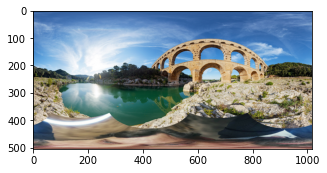

In [23]:
plt.imshow(cv2.cvtColor(equirectangular_image, cv2.COLOR_BGR2RGB))
plt.show()

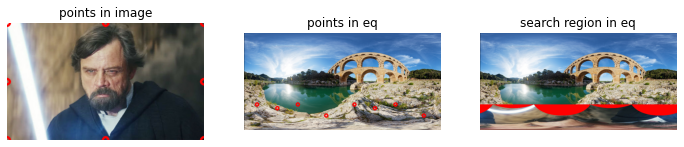

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

titles = ['points in image', 'points in eq', 'search region in eq']

for i, ax in enumerate(axes):
    ax.set_title(titles[i])
    ax.imshow(cv2.cvtColor(interm_images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.show()